## Modelling with XGBoost
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    classification_report,
    f1_score,
    roc_curve,
    roc_auc_score,
    RocCurveDisplay,
)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
df = pd.read_parquet("api/data/transactions.parquet")

In [3]:
# df = pd.read_parquet("api/data/transactions.parquet")

# Create new columns for the month, day, and weekday
df["Order_Date_FK_datetime"] = pd.to_datetime(df["Order_Date_FK"], format="%Y%m%d")
df["Month"] = df["Order_Date_FK_datetime"].dt.month
df["Day"] = df["Order_Date_FK_datetime"].dt.day
df["Weekday"] = df["Order_Date_FK_datetime"].dt.weekday
df.drop(
    columns=["Order_Date_FK_datetime"], inplace=True
)  # Drop the original date column
df["Webshop"] = np.where((df.Shop > 99), 1, 0)

"""
df[
    [
        "Shop",
        "ProductCode",
        "CustomerID",
        "SaleDocumentNumber",
        "BrandName",
        "ModelGroup",
        "ProductGroup",
        "Order_Date_FK",
    ]
] = df[
    [
        "Shop",
        "ProductCode",
        "CustomerID",
        "SaleDocumentNumber",
        "BrandName",
        "ModelGroup",
        "ProductGroup",
        "Order_Date_FK",
    ]
].astype("O")
"""

df[["OriginalSaleAmountInclVAT", "RevenueInclVAT", "CostPriceExclVAT"]] = df[
    ["OriginalSaleAmountInclVAT", "RevenueInclVAT", "CostPriceExclVAT"]
].astype("float64")

df[["Month", "Day", "Weekday", "Webshop"]] = df[
    ["Month", "Day", "Weekday", "Webshop"]
].astype("int64")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759889 entries, 0 to 1759888
Data columns (total 16 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Shop                       int64  
 1   Order_Date_FK              int64  
 2   ProductCode                int64  
 3   OriginalSaleAmountInclVAT  float64
 4   CustomerID                 int64  
 5   SaleDocumentNumber         int64  
 6   Returned                   int64  
 7   RevenueInclVAT             float64
 8   CostPriceExclVAT           float64
 9   BrandName                  int64  
 10  ModelGroup                 int64  
 11  ProductGroup               int64  
 12  Month                      int64  
 13  Day                        int64  
 14  Weekday                    int64  
 15  Webshop                    int64  
dtypes: float64(3), int64(13)
memory usage: 214.8 MB


In [ ]:
df.BrandName.nunique()

649

In [4]:
numerical_feautures = [
    "OriginalSaleAmountInclVAT",
    "RevenueInclVAT",
    "CostPriceExclVAT",
]

# BrandName has 649 unique values
categorical_features = [
    "Shop",
    "ModelGroup",
    "ProductGroup",
    "BrandName",
    "ProductCode",
    "CustomerID",
    "SaleDocumentNumber",
    "Order_Date_FK",
    "Month",
    "Day",
    "Weekday",
]

fl_features = ["Webshop"]

In [5]:
# Split the data into features (X) and target (y)
X = df[numerical_feautures + categorical_features + fl_features]
y = df["Returned"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# OneHotEncode the categorical features
enc = OneHotEncoder(handle_unknown="ignore", max_categories=20)
enc.fit(X_train[categorical_features])
X_train_cat = enc.transform(X_train[categorical_features]).toarray()
X_test_cat = enc.transform(X_test[categorical_features]).toarray()


# Combine the numerical and one-hot encoded categorical columns
X_train = pd.concat(
    [
        X_train[numerical_feautures + fl_features].reset_index(drop=True),
        pd.DataFrame(X_train_cat, columns=enc.get_feature_names_out()),
    ],
    axis=1,
)

X_test = pd.concat(
    [
        X_test[numerical_feautures + fl_features].reset_index(drop=True),
        pd.DataFrame(X_test_cat, columns=enc.get_feature_names_out()),
    ],
    axis=1,
)

In [ ]:
bst = XGBClassifier()
bst.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = bst.predict(X_test)

# Calculate the accuracy of the model.

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}".format(f1))

# Display the classification report and confusion matrix.

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 96.16%
Precision: 56.02%
Recall: 0.69%
F1 Score: 0.01
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    338450
           1       0.56      0.01      0.01     13528

    accuracy                           0.96    351978
   macro avg       0.76      0.50      0.50    351978
weighted avg       0.95      0.96      0.94    351978

Confusion Matrix:
[[338377     73]
 [ 13435     93]]


In [66]:
y_pred_proba = bst.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print("Best Threshold=%f" % (best_thresh))

Best Threshold=0.484846


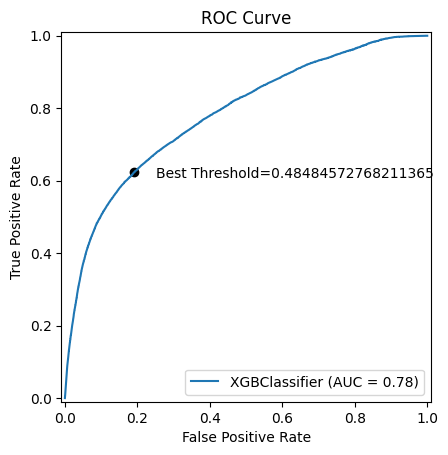

In [67]:
display = RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="XGBClassifier"
)
display.plot()
plt.scatter(fpr[ix], tpr[ix], marker="o", color="black")
plt.text(fpr[ix] + 0.06, tpr[ix] - 0.015, f"Best Threshold={best_thresh}")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

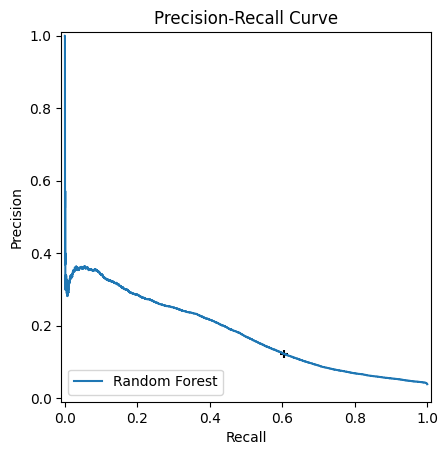

In [68]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

prec, rec, _ = precision_recall_curve(y_test, y_pred_proba)
pr_display = PrecisionRecallDisplay(
    precision=prec, recall=rec, estimator_name="Random Forest"
)
pr_display.plot()
plt.scatter(recall, precision, marker="+", color="black")
# plt.axvline(x=0.51, color="green", linestyle="--")
# plt.axhline(y=0.89, color="red", linestyle="--")
plt.title("Precision-Recall Curve")
plt.show()

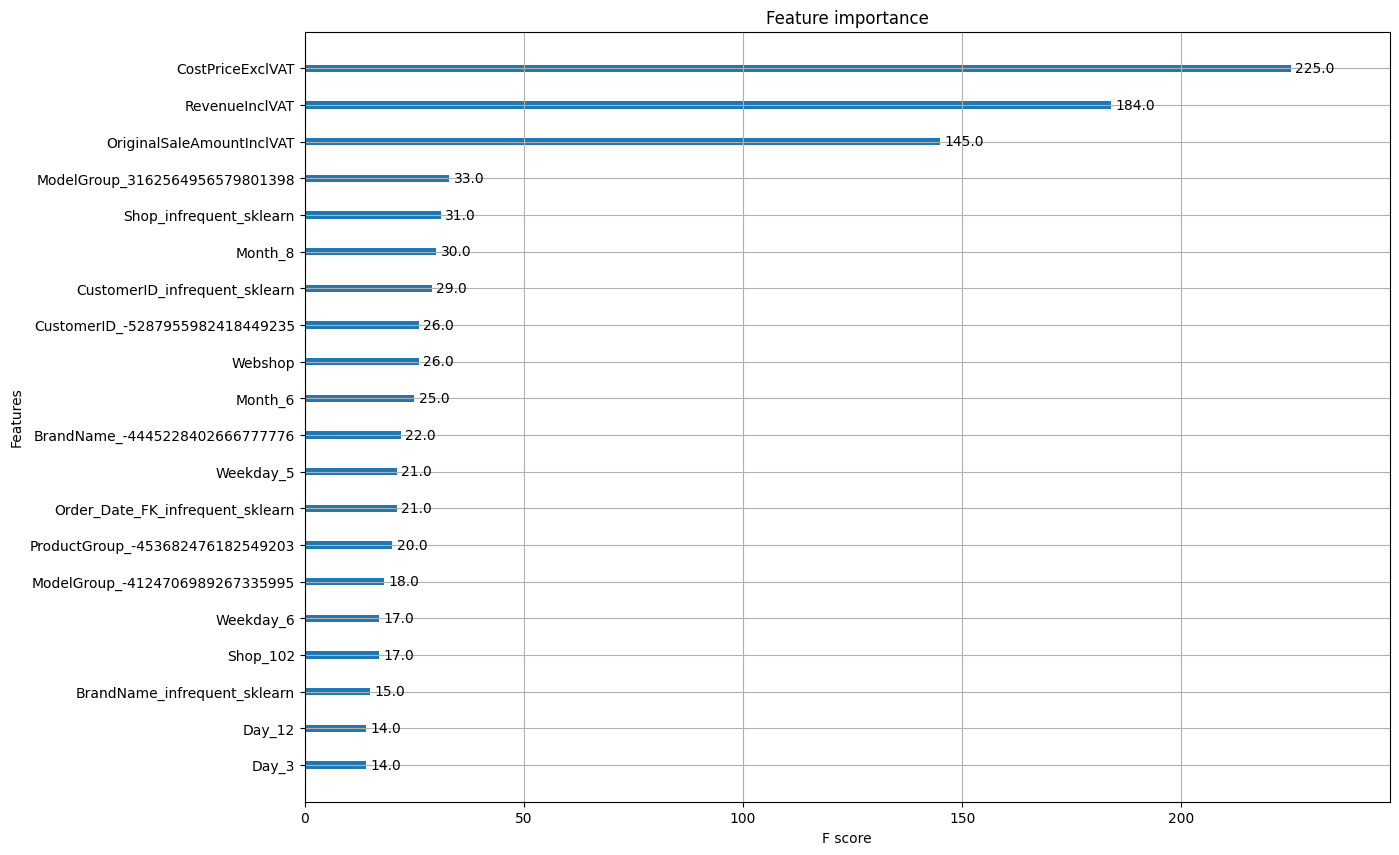

In [69]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plot_importance(bst, ax=ax, max_num_features=20)
# plot_tree(xgb1, ax=ax)
plt.show()

In [6]:
random_grid = {
    "max_depth": [4, 5, 6],
    "n_estimators": [20, 22, 24],
    "scale_pos_weight": [20, 22, 24],
}

In [7]:
bst_rand = XGBClassifier()

grid = RandomizedSearchCV(
    estimator=bst_rand,
    param_distributions=random_grid,
    cv=4,
    verbose=2,
    random_state=42,
    n_jobs=4,
    scoring="recall",
)

# over = SMOTE(sampling_strategy=0.1)
# under = RandomUnderSampler(sampling_strategy=0.5)
# steps = [("o", over), ("u", under), ("model", grid)]
# pipeline = Pipeline(steps=steps)

grid.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=4,
                   param_distributions={'max_depth': [4, 5, 6],
                                        'n_estimators': [20, 22, 24],
                                        'scale_pos_weight': [20, 22, 24]},
                   random_state=42, scoring='recall', verbose=2)

In [8]:
grid.best_params_

{'scale_pos_weight': 24, 'n_estimators': 24, 'max_depth': 5}

In [16]:
ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]
print(ratio)

24.944146534726446


In [64]:
bst = XGBClassifier(
    n_estimators=40,
    max_depth=6,
    scale_pos_weight=25,
)

bst.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=40, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [9]:
y_pred = grid.best_estimator_.predict(X_test)
print(y_pred, y_pred.shape)

# Calculate the accuracy of the model.

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}".format(f1))


# Display the classification report and confusion matrix.

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

[0 0 0 ... 1 0 0] (351978,)
Accuracy: 82.78%
Precision: 12.57%
Recall: 58.43%
F1 Score: 0.21
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.90    338450
           1       0.13      0.58      0.21     13528

    accuracy                           0.83    351978
   macro avg       0.55      0.71      0.56    351978
weighted avg       0.95      0.83      0.88    351978

Confusion Matrix:
[[283473  54977]
 [  5624   7904]]


---
---
---
---

In [ ]:
# grid search positive class weights with xgboost for imbalance classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

# define model
model = XGBClassifier()
# define grid
weights = [14, 16, 18, 20, 22, 24, 26, 28, 30]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(
    estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring="f1"
)
# execute the grid search
grid_result = grid.fit(X, y)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.992989 using {'scale_pos_weight': 1000}
0.006643 (0.001101) with: {'scale_pos_weight': 1}
0.474661 (0.006389) with: {'scale_pos_weight': 10}
0.668210 (0.005226) with: {'scale_pos_weight': 25}
0.876677 (0.004196) with: {'scale_pos_weight': 50}
0.953851 (0.003251) with: {'scale_pos_weight': 75}
0.976399 (0.001996) with: {'scale_pos_weight': 99}
0.976808 (0.002351) with: {'scale_pos_weight': 100}
0.992989 (0.001149) with: {'scale_pos_weight': 1000}


In [ ]:
bst_weighted = XGBClassifier(random_state=42, scale_pos_weight=1000)
bst_weighted.fit(X_train, y_train)

XGBoostError: [11:41:53] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\io.h:232: bad_malloc: Failed to allocate 1091131025 bytes.

In [ ]:
y_pred = pipeline.predict(X_test)

# Calculate the accuracy of the model.

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}".format(f1))

# Display the classification report and confusion matrix.

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

ValueError: feature_names mismatch: ['Order_Date_FK', 'ProductCode', 'OriginalSaleAmountInclVAT', 'CustomerID', 'SaleDocumentNumber', 'RevenueInclVAT', 'CostPriceExclVAT', 'Month', 'Day', 'Weekday', 'BrandName', 'Webshop', 'Shop_1', 'Shop_2', 'Shop_3', 'Shop_4', 'Shop_5', 'Shop_6', 'Shop_7', 'Shop_8', 'Shop_9', 'Shop_10', 'Shop_11', 'Shop_12', 'Shop_13', 'Shop_14', 'Shop_15', 'Shop_16', 'Shop_18', 'Shop_19', 'Shop_20', 'Shop_21', 'Shop_22', 'Shop_23', 'Shop_24', 'Shop_25', 'Shop_26', 'Shop_27', 'Shop_28', 'Shop_29', 'Shop_30', 'Shop_31', 'Shop_32', 'Shop_33', 'Shop_34', 'Shop_35', 'Shop_36', 'Shop_37', 'Shop_38', 'Shop_41', 'Shop_42', 'Shop_43', 'Shop_44', 'Shop_45', 'Shop_46', 'Shop_47', 'Shop_48', 'Shop_49', 'Shop_50', 'Shop_51', 'Shop_52', 'Shop_53', 'Shop_54', 'Shop_55', 'Shop_56', 'Shop_57', 'Shop_58', 'Shop_59', 'Shop_60', 'Shop_61', 'Shop_62', 'Shop_63', 'Shop_64', 'Shop_65', 'Shop_66', 'Shop_67', 'Shop_68', 'Shop_69', 'Shop_70', 'Shop_71', 'Shop_72', 'Shop_73', 'Shop_74', 'Shop_75', 'Shop_76', 'Shop_77', 'Shop_78', 'Shop_79', 'Shop_80', 'Shop_81', 'Shop_82', 'Shop_83', 'Shop_84', 'Shop_85', 'Shop_86', 'Shop_102', 'Shop_103', 'ModelGroup_-8581610949319170507', 'ModelGroup_-7693559481885520974', 'ModelGroup_-6715310361529623819', 'ModelGroup_-6534481151174441087', 'ModelGroup_-4124706989267335995', 'ModelGroup_-3922898513625196790', 'ModelGroup_-3872800907285994177', 'ModelGroup_-3435156612027683252', 'ModelGroup_-3170699624988567198', 'ModelGroup_-2724180456806002628', 'ModelGroup_-2426224035638420213', 'ModelGroup_-2375149457939821456', 'ModelGroup_-1985744308537605242', 'ModelGroup_-1330987452709117740', 'ModelGroup_-1172740817228586022', 'ModelGroup_-965590225519141271', 'ModelGroup_-837118628879098305', 'ModelGroup_-713617190452378892', 'ModelGroup_-248459121805647149', 'ModelGroup_1489039468818000734', 'ModelGroup_1570852240237176153', 'ModelGroup_1731648819243485246', 'ModelGroup_2552887355222480171', 'ModelGroup_3162564956579801398', 'ModelGroup_4869021320883412095', 'ModelGroup_5225781503558000414', 'ModelGroup_5481784830694155153', 'ModelGroup_5751729717380170889', 'ModelGroup_6450924088821678307', 'ModelGroup_6742804956075612187', 'ModelGroup_7383880531496163867', 'ModelGroup_8676381074854750838', 'ProductGroup_-5386210342051699146', 'ProductGroup_-453682476182549203', 'ProductGroup_2500932515802331300', 'ProductGroup_5294166889150293396', 'ProductGroup_5965103661511607192', 'ProductGroup_7941416848777047762'] ['Order_Date_FK', 'ProductCode', 'OriginalSaleAmountInclVAT', 'CustomerID', 'SaleDocumentNumber', 'RevenueInclVAT', 'CostPriceExclVAT', 'Month', 'Day', 'Weekday', 'Webshop', 'Shop_1', 'Shop_2', 'Shop_3', 'Shop_4', 'Shop_5', 'Shop_6', 'Shop_7', 'Shop_8', 'Shop_9', 'Shop_10', 'Shop_11', 'Shop_12', 'Shop_13', 'Shop_14', 'Shop_15', 'Shop_16', 'Shop_18', 'Shop_19', 'Shop_20', 'Shop_21', 'Shop_22', 'Shop_23', 'Shop_24', 'Shop_25', 'Shop_26', 'Shop_27', 'Shop_28', 'Shop_29', 'Shop_30', 'Shop_31', 'Shop_32', 'Shop_33', 'Shop_34', 'Shop_35', 'Shop_36', 'Shop_37', 'Shop_38', 'Shop_41', 'Shop_42', 'Shop_43', 'Shop_44', 'Shop_45', 'Shop_46', 'Shop_47', 'Shop_48', 'Shop_49', 'Shop_50', 'Shop_51', 'Shop_52', 'Shop_53', 'Shop_54', 'Shop_55', 'Shop_56', 'Shop_57', 'Shop_58', 'Shop_59', 'Shop_60', 'Shop_61', 'Shop_62', 'Shop_63', 'Shop_64', 'Shop_65', 'Shop_66', 'Shop_67', 'Shop_68', 'Shop_69', 'Shop_70', 'Shop_71', 'Shop_72', 'Shop_73', 'Shop_74', 'Shop_75', 'Shop_76', 'Shop_77', 'Shop_78', 'Shop_79', 'Shop_80', 'Shop_81', 'Shop_82', 'Shop_83', 'Shop_84', 'Shop_85', 'Shop_86', 'Shop_102', 'Shop_103', 'ModelGroup_-8581610949319170507', 'ModelGroup_-7693559481885520974', 'ModelGroup_-6715310361529623819', 'ModelGroup_-6534481151174441087', 'ModelGroup_-4124706989267335995', 'ModelGroup_-3922898513625196790', 'ModelGroup_-3872800907285994177', 'ModelGroup_-3435156612027683252', 'ModelGroup_-3170699624988567198', 'ModelGroup_-2724180456806002628', 'ModelGroup_-2426224035638420213', 'ModelGroup_-2375149457939821456', 'ModelGroup_-1985744308537605242', 'ModelGroup_-1330987452709117740', 'ModelGroup_-1172740817228586022', 'ModelGroup_-965590225519141271', 'ModelGroup_-837118628879098305', 'ModelGroup_-713617190452378892', 'ModelGroup_-248459121805647149', 'ModelGroup_1489039468818000734', 'ModelGroup_1570852240237176153', 'ModelGroup_1731648819243485246', 'ModelGroup_2552887355222480171', 'ModelGroup_3162564956579801398', 'ModelGroup_4869021320883412095', 'ModelGroup_5225781503558000414', 'ModelGroup_5481784830694155153', 'ModelGroup_5751729717380170889', 'ModelGroup_6450924088821678307', 'ModelGroup_6742804956075612187', 'ModelGroup_7383880531496163867', 'ModelGroup_8676381074854750838', 'ProductGroup_-5386210342051699146', 'ProductGroup_-453682476182549203', 'ProductGroup_2500932515802331300', 'ProductGroup_5294166889150293396', 'ProductGroup_5965103661511607192', 'ProductGroup_7941416848777047762', 'BrandName_-9188398371112724402', 'BrandName_-9154070123208926236', 'BrandName_-9121749129799555055', 'BrandName_-9111042495772325286', 'BrandName_-9090118194139054394', 'BrandName_-9078538943288567323', 'BrandName_-9062336570377819567', 'BrandName_-9005659178644430201', 'BrandName_-8999899410032716445', 'BrandName_-8979024533378815955', 'BrandName_-8954910989133076063', 'BrandName_-8947834980723594713', 'BrandName_-8923598081100678797', 'BrandName_-8892132782483441489', 'BrandName_-8846961206607438497', 'BrandName_-8837156944700120232', 'BrandName_-8824491806484121188', 'BrandName_-8799839500989161418', 'BrandName_-8796795454043864483', 'BrandName_-8785012876444315414', 'BrandName_-8710939345520521313', 'BrandName_-8695230245319396654', 'BrandName_-8580902209269090728', 'BrandName_-8557656514988105102', 'BrandName_-8518831816578857642', 'BrandName_-8507421977918128293', 'BrandName_-8480085633621514149', 'BrandName_-8479843323191308406', 'BrandName_-8450401210316132824', 'BrandName_-8447540709973074272', 'BrandName_-8345337960573743785', 'BrandName_-8334110515734058988', 'BrandName_-8325685586121808828', 'BrandName_-8269593306827619339', 'BrandName_-8247614199984445610', 'BrandName_-8227887427753257615', 'BrandName_-8226815305188357247', 'BrandName_-8226606284663833988', 'BrandName_-8211132834900119501', 'BrandName_-8157167840070521711', 'BrandName_-8124814078271782692', 'BrandName_-8116428172524396380', 'BrandName_-8094689887272758834', 'BrandName_-8093519676797838569', 'BrandName_-8037958501555372180', 'BrandName_-8004900333482617950', 'BrandName_-7983271993154044788', 'BrandName_-7949999021276310690', 'BrandName_-7946506220046412185', 'BrandName_-7921480381513708220', 'BrandName_-7917299039615079351', 'BrandName_-7897023959440384421', 'BrandName_-7880303410445226392', 'BrandName_-7843373650616841940', 'BrandName_-7827463481178904503', 'BrandName_-7752534956475381365', 'BrandName_-7744756991733696495', 'BrandName_-7743447376991754988', 'BrandName_-7690906715625044707', 'BrandName_-7604046680656498816', 'BrandName_-7598563758776373721', 'BrandName_-7531140312121418030', 'BrandName_-7475450093996584774', 'BrandName_-7449198598313854900', 'BrandName_-7381249179680483141', 'BrandName_-7365122509301830737', 'BrandName_-7343124724520642478', 'BrandName_-7321669684617571325', 'BrandName_-7271603625604196716', 'BrandName_-7244046429025905887', 'BrandName_-7239898660772760224', 'BrandName_-7222781314436729574', 'BrandName_-7202472198306336051', 'BrandName_-7177370704634981598', 'BrandName_-7130095634701368819', 'BrandName_-7110140718088759928', 'BrandName_-7076806722268766675', 'BrandName_-7047427872937636123', 'BrandName_-6988743831713857166', 'BrandName_-6955911255035127656', 'BrandName_-6950422565880610468', 'BrandName_-6911073086623797879', 'BrandName_-6872531332918406988', 'BrandName_-6850025193650062375', 'BrandName_-6772702132133161775', 'BrandName_-6766044160287846507', 'BrandName_-6748390569695848513', 'BrandName_-6733487286118295251', 'BrandName_-6730696869481602475', 'BrandName_-6643539960506150402', 'BrandName_-6631123102709146694', 'BrandName_-6624982080437927419', 'BrandName_-6539761422427431658', 'BrandName_-6531487396880310820', 'BrandName_-6479302783261211626', 'BrandName_-6453598337868284116', 'BrandName_-6422525705883118536', 'BrandName_-6413968958848624629', 'BrandName_-6395021237485058557', 'BrandName_-6333061753568435229', 'BrandName_-6333004322260999075', 'BrandName_-6289901634530649940', 'BrandName_-6240098752987791016', 'BrandName_-6225424938583074484', 'BrandName_-6189321870590252275', 'BrandName_-6188347972936224795', 'BrandName_-6126106693333975066', 'BrandName_-6085344424757178962', 'BrandName_-6070255228673919044', 'BrandName_-6005890594686252799', 'BrandName_-5995504661184576677', 'BrandName_-5994336774303575498', 'BrandName_-5957250855210977509', 'BrandName_-5941507916241681762', 'BrandName_-5933562002465328616', 'BrandName_-5878014476118860902', 'BrandName_-5836951741725504951', 'BrandName_-5813604796133860680', 'BrandName_-5654886179153799272', 'BrandName_-5600699091420318364', 'BrandName_-5590499895529761387', 'BrandName_-5472214903714221650', 'BrandName_-5465668627794274636', 'BrandName_-5446719505677571815', 'BrandName_-5407567327938936999', 'BrandName_-5391823799400194019', 'BrandName_-5350595956900711273', 'BrandName_-5347358614475033638', 'BrandName_-5337325358582794831', 'BrandName_-5335685962261922864', 'BrandName_-5314626712748974787', 'BrandName_-5274589759190027618', 'BrandName_-5262579144347438027', 'BrandName_-5236678246318113289', 'BrandName_-5161706614068533757', 'BrandName_-5142529040366179392', 'BrandName_-5124247384998812255', 'BrandName_-5050386846559608408', 'BrandName_-5047068914426116142', 'BrandName_-5026859679180461575', 'BrandName_-4986267292944148585', 'BrandName_-4971864554893299075', 'BrandName_-4873671765945300432', 'BrandName_-4869459690934553786', 'BrandName_-4838583714854068434', 'BrandName_-4838418729894832550', 'BrandName_-4832619392258863219', 'BrandName_-4815350507482526440', 'BrandName_-4785002223751504736', 'BrandName_-4744783209248077985', 'BrandName_-4739224219113218902', 'BrandName_-4680657082568794485', 'BrandName_-4666959441471070182', 'BrandName_-4665184855541312219', 'BrandName_-4649920888907449095', 'BrandName_-4606403254425245430', 'BrandName_-4596715116777480052', 'BrandName_-4592729266647143609', 'BrandName_-4545347594098775461', 'BrandName_-4529532282812805513', 'BrandName_-4513016650978148382', 'BrandName_-4511632357930907122', 'BrandName_-4489601390862061622', 'BrandName_-4482054268728543066', 'BrandName_-4445228402666777776', 'BrandName_-4410579612107183725', 'BrandName_-4402726635693583246', 'BrandName_-4401392805508762273', 'BrandName_-4381869678953560643', 'BrandName_-4368231279756248641', 'BrandName_-4368095084573731360', 'BrandName_-4332997125348628659', 'BrandName_-4328451245737343620', 'BrandName_-4324072422255143033', 'BrandName_-4315922682648167120', 'BrandName_-4311360173027929071', 'BrandName_-4236544508055957518', 'BrandName_-4153661465865982274', 'BrandName_-4096554515652180411', 'BrandName_-4087396388609311917', 'BrandName_-4063446204334150757', 'BrandName_-4050499380292658399', 'BrandName_-4023244649488710519', 'BrandName_-3963807916308591080', 'BrandName_-3916664911255158352', 'BrandName_-3903584845100619744', 'BrandName_-3887622957618252991', 'BrandName_-3849501745278201267', 'BrandName_-3825500669951573656', 'BrandName_-3810911171434227220', 'BrandName_-3780750431027967665', 'BrandName_-3779918776512366535', 'BrandName_-3742669642879178775', 'BrandName_-3734237314099258167', 'BrandName_-3707261398553321197', 'BrandName_-3693957764767261153', 'BrandName_-3676120587417287087', 'BrandName_-3675112973322784177', 'BrandName_-3641555175027465110', 'BrandName_-3617217182357930127', 'BrandName_-3584159226591102187', 'BrandName_-3582514195420697870', 'BrandName_-3563500074228052866', 'BrandName_-3545922579559861628', 'BrandName_-3535268279011411199', 'BrandName_-3438126112696402523', 'BrandName_-3427191694094858391', 'BrandName_-3400725434885786352', 'BrandName_-3396845633700263552', 'BrandName_-3143763826631182660', 'BrandName_-3121092183391892989', 'BrandName_-3095338956980783177', 'BrandName_-3032463610581223200', 'BrandName_-3006657024397325680', 'BrandName_-3001169043836376081', 'BrandName_-2960283518207579103', 'BrandName_-2845885560689183090', 'BrandName_-2828498183916938059', 'BrandName_-2820777137517483750', 'BrandName_-2820197887791128246', 'BrandName_-2751659245209050689', 'BrandName_-2672088214784283300', 'BrandName_-2638400111266039707', 'BrandName_-2618563188908540456', 'BrandName_-2573306833587344411', 'BrandName_-2568864215948658375', 'BrandName_-2560555226348769223', 'BrandName_-2548578512308621865', 'BrandName_-2517183108039798740', 'BrandName_-2458827512483484933', 'BrandName_-2444919046141572778', 'BrandName_-2377958491307722767', 'BrandName_-2347707393475472096', 'BrandName_-2307120136224419728', 'BrandName_-2244913371577821638', 'BrandName_-2241137460007393813', 'BrandName_-2222828176005290305', 'BrandName_-2150588861025064343', 'BrandName_-2116821022605566018', 'BrandName_-2102845757278046834', 'BrandName_-2089118211830753390', 'BrandName_-2074012670196538378', 'BrandName_-2041464652498643948', 'BrandName_-2025693028589585620', 'BrandName_-2024356269028207059', 'BrandName_-1986475675327888626', 'BrandName_-1977568287562547862', 'BrandName_-1973842268148730396', 'BrandName_-1876825363450693260', 'BrandName_-1873787772202565890', 'BrandName_-1868194209156870455', 'BrandName_-1850777464522541048', 'BrandName_-1803677233667612926', 'BrandName_-1800442188412919501', 'BrandName_-1776458903022143360', 'BrandName_-1718649967102290520', 'BrandName_-1696856521753024883', 'BrandName_-1677272881830656139', 'BrandName_-1671135878886367730', 'BrandName_-1657270726128381662', 'BrandName_-1622080118590624720', 'BrandName_-1596899656215821153', 'BrandName_-1437369890310911040', 'BrandName_-1426118782691437192', 'BrandName_-1416718224283108732', 'BrandName_-1415265220685287790', 'BrandName_-1405688680336340446', 'BrandName_-1391715900861285672', 'BrandName_-1391008879527485205', 'BrandName_-1366072440066821101', 'BrandName_-1348603744134651385', 'BrandName_-1335138822755510848', 'BrandName_-1325724573720918103', 'BrandName_-1307137263094964199', 'BrandName_-1297129435627585630', 'BrandName_-1236916485032997820', 'BrandName_-1183861844137376173', 'BrandName_-1179193310456922433', 'BrandName_-1159077491048515811', 'BrandName_-1125747160593961203', 'BrandName_-1027418522342806914', 'BrandName_-977190893831454675', 'BrandName_-913163949100757264', 'BrandName_-872797489046909906', 'BrandName_-836999452771552605', 'BrandName_-773400081614489537', 'BrandName_-772271000621176923', 'BrandName_-764500920431797262', 'BrandName_-711154948483050917', 'BrandName_-695245205599557550', 'BrandName_-678575059128212312', 'BrandName_-664325963891452007', 'BrandName_-632115612641285033', 'BrandName_-615053178468500597', 'BrandName_-566762273326745508', 'BrandName_-559883191624195265', 'BrandName_-454931241180261732', 'BrandName_-440575060290487877', 'BrandName_-424472638565217610', 'BrandName_-245683579395616188', 'BrandName_-229431284073687234', 'BrandName_-201512039918722683', 'BrandName_-182964242891401153', 'BrandName_-165403846088755788', 'BrandName_-150227863615970749', 'BrandName_-125034898080947978', 'BrandName_-34764204039673987', 'BrandName_-20244570661198431', 'BrandName_-7709125174244191', 'BrandName_23455201725242580', 'BrandName_33538854880025124', 'BrandName_61861539175299892', 'BrandName_96584880849886171', 'BrandName_98233977284132774', 'BrandName_129136977595581806', 'BrandName_324072397369012430', 'BrandName_338992500799104519', 'BrandName_353342615826014806', 'BrandName_385997063778803842', 'BrandName_411761877147485289', 'BrandName_455810540295740948', 'BrandName_457149490632824199', 'BrandName_478680236861330469', 'BrandName_521292054760386925', 'BrandName_567081484845833482', 'BrandName_595620585719013230', 'BrandName_611049624476511346', 'BrandName_656580209475949020', 'BrandName_688207797474356501', 'BrandName_707287891818124803', 'BrandName_730266934036041707', 'BrandName_733719324481276844', 'BrandName_759766973375394817', 'BrandName_768744885002133727', 'BrandName_819082341107646127', 'BrandName_860585477618606420', 'BrandName_895024596096459527', 'BrandName_903669804140988163', 'BrandName_946019608772493539', 'BrandName_991494341429516798', 'BrandName_999370235819166916', 'BrandName_1020727033903757954', 'BrandName_1025531607436531853', 'BrandName_1095016664268974027', 'BrandName_1101647827401594784', 'BrandName_1115670815986511919', 'BrandName_1168115093187640245', 'BrandName_1207635555724531789', 'BrandName_1226431715265999568', 'BrandName_1237514051594295000', 'BrandName_1243166087040633730', 'BrandName_1245693351570808307', 'BrandName_1264876806116620763', 'BrandName_1281557525461678651', 'BrandName_1303002123683883878', 'BrandName_1318209578467575247', 'BrandName_1322002847928527760', 'BrandName_1325016225504816809', 'BrandName_1355478441290564448', 'BrandName_1369216405130752032', 'BrandName_1390844678342921098', 'BrandName_1408198926614584084', 'BrandName_1422228892962323368', 'BrandName_1442388124545020900', 'BrandName_1458207520693512303', 'BrandName_1549528293440166875', 'BrandName_1605171619481756756', 'BrandName_1619702792637556622', 'BrandName_1622400610803807502', 'BrandName_1623874938686412446', 'BrandName_1624165817153056647', 'BrandName_1637121416984739763', 'BrandName_1646201712745910052', 'BrandName_1666677203189162889', 'BrandName_1690261075636558403', 'BrandName_1707772265470062909', 'BrandName_1758689180329012984', 'BrandName_1804823000292807462', 'BrandName_1811867207097181119', 'BrandName_1819973842741296615', 'BrandName_1857397174565186841', 'BrandName_1857918515453071333', 'BrandName_1882194062118336910', 'BrandName_1922432125482374776', 'BrandName_1923804194533887066', 'BrandName_1937538370573603896', 'BrandName_1946126913072699840', 'BrandName_1956712595346677142', 'BrandName_1959370762585489182', 'BrandName_1983739444144689897', 'BrandName_2028411782432658636', 'BrandName_2036393273428736773', 'BrandName_2055667782685269172', 'BrandName_2066021225084704219', 'BrandName_2093110448892988363', 'BrandName_2119881133225556517', 'BrandName_2163194981545980604', 'BrandName_2273757653109568324', 'BrandName_2283785828203137857', 'BrandName_2307044913735890614', 'BrandName_2345777216533989925', 'BrandName_2347669528057263491', 'BrandName_2374378264535652962', 'BrandName_2374418896701300420', 'BrandName_2397022673953116090', 'BrandName_2421721180250390754', 'BrandName_2422118029599885529', 'BrandName_2545262347132167695', 'BrandName_2591896159027939062', 'BrandName_2610152986705088844', 'BrandName_2624591207543434836', 'BrandName_2649987921697068107', 'BrandName_2657840034576389085', 'BrandName_2662848080598789796', 'BrandName_2720091876038064899', 'BrandName_2776326510072975976', 'BrandName_2783596878032591777', 'BrandName_2792911015117637224', 'BrandName_2859921358416244789', 'BrandName_2928571123589660622', 'BrandName_2929359717839159554', 'BrandName_2972142487631325149', 'BrandName_3023730740545269934', 'BrandName_3025871011308122903', 'BrandName_3042329836844856447', 'BrandName_3062952708946944530', 'BrandName_3067055127235792305', 'BrandName_3089118227041643239', 'BrandName_3147597281999378922', 'BrandName_3196347062832329622', 'BrandName_3197208407420106051', 'BrandName_3229309677472091984', 'BrandName_3232188062704294859', 'BrandName_3252601169136630370', 'BrandName_3257897796000051910', 'BrandName_3289787337165538824', 'BrandName_3368622656316571008', 'BrandName_3437178367947620787', 'BrandName_3438308094390080321', 'BrandName_3468461539383822076', 'BrandName_3509851629598376215', 'BrandName_3543782737739631559', 'BrandName_3544392051689411539', 'BrandName_3563091515111660860', 'BrandName_3584552690031221850', 'BrandName_3597758713044105304', 'BrandName_3620420599834340975', 'BrandName_3694837121284491212', 'BrandName_3794763860193133624', 'BrandName_3846483209212943975', 'BrandName_3879087702488298300', 'BrandName_3918785047514149591', 'BrandName_3925407471043494199', 'BrandName_3963737480881445151', 'BrandName_4026470625079026730', 'BrandName_4032473902668557875', 'BrandName_4037616015241687040', 'BrandName_4074140965931600786', 'BrandName_4095319210458731150', 'BrandName_4127404528373522682', 'BrandName_4128020524755247371', 'BrandName_4146548197554312351', 'BrandName_4151160798088233154', 'BrandName_4170787242213559438', 'BrandName_4184592167825337056', 'BrandName_4199080922851584611', 'BrandName_4229820173661692180', 'BrandName_4260140701844019796', 'BrandName_4273291718193616705', 'BrandName_4282801151570674933', 'BrandName_4291366895408796699', 'BrandName_4345864700805333777', 'BrandName_4348082800121216804', 'BrandName_4383187266072684529', 'BrandName_4442973692634862764', 'BrandName_4463868324098739621', 'BrandName_4508758683635503322', 'BrandName_4592197325153416641', 'BrandName_4609502843107529640', 'BrandName_4614247681931237507', 'BrandName_4624258855182506707', 'BrandName_4641005119550481432', 'BrandName_4682361090651584500', 'BrandName_4717096102405955547', 'BrandName_4738859367515403314', 'BrandName_4759197292865645888', 'BrandName_4775146587781559798', 'BrandName_4836077903955926009', 'BrandName_4856789551360624328', 'BrandName_4858808358632097913', 'BrandName_4892464737825172108', 'BrandName_4937688635047792501', 'BrandName_4969110592732195590', 'BrandName_4979539231566292275', 'BrandName_5007755042245949661', 'BrandName_5009754461103609913', 'BrandName_5047114352497885856', 'BrandName_5061068245105928431', 'BrandName_5106839180430815414', 'BrandName_5107977064651864891', 'BrandName_5115948388309883499', 'BrandName_5126649413550967392', 'BrandName_5129498378013869771', 'BrandName_5158340465572340446', 'BrandName_5207388479226334778', 'BrandName_5312899804999756107', 'BrandName_5346947443053517783', 'BrandName_5353088918822222008', 'BrandName_5365993094971572787', 'BrandName_5409039384584300061', 'BrandName_5437462610578617133', 'BrandName_5466482132442460214', 'BrandName_5471248645805557200', 'BrandName_5549000098502522985', 'BrandName_5598027708586291180', 'BrandName_5632176822166406849', 'BrandName_5706912887980628352', 'BrandName_5713556995711374509', 'BrandName_5790168446645161831', 'BrandName_5822023969050643133', 'BrandName_5831759292899087530', 'BrandName_5889463741011945411', 'BrandName_5894517056794498583', 'BrandName_5911748161695540460', 'BrandName_5938740758584178118', 'BrandName_6048238985489442235', 'BrandName_6063357103893182093', 'BrandName_6108985138393752382', 'BrandName_6110529426657756380', 'BrandName_6164254645951948400', 'BrandName_6175268986818906156', 'BrandName_6218941629236235822', 'BrandName_6283975440534064981', 'BrandName_6311976704084396677', 'BrandName_6323243433822375072', 'BrandName_6390963756949052290', 'BrandName_6407322060712425677', 'BrandName_6415706435346315987', 'BrandName_6428651561076535000', 'BrandName_6482374115656801944', 'BrandName_6551658593778198243', 'BrandName_6577702152217227983', 'BrandName_6594332787890886858', 'BrandName_6610499257614818371', 'BrandName_6664248748733948541', 'BrandName_6677298575854461833', 'BrandName_6698009202864455348', 'BrandName_6702387185443404386', 'BrandName_6728723587976834800', 'BrandName_6800997636733475524', 'BrandName_6805609118829355942', 'BrandName_6844487761873649804', 'BrandName_6862799060630055392', 'BrandName_6863978239792763037', 'BrandName_6866427087015634695', 'BrandName_6891069932565275689', 'BrandName_6915377390296748661', 'BrandName_6917586606698131488', 'BrandName_6951699009579718897', 'BrandName_6979718338610853154', 'BrandName_6984435142940638685', 'BrandName_6986006458690835616', 'BrandName_6986028877481303378', 'BrandName_6988179278806901179', 'BrandName_7001045920440433929', 'BrandName_7020846239121976745', 'BrandName_7029235832649926501', 'BrandName_7063266999961497672', 'BrandName_7090776369763609872', 'BrandName_7100782428228773803', 'BrandName_7160012309412169843', 'BrandName_7163298684789717024', 'BrandName_7178777430365303508', 'BrandName_7179783357086749422', 'BrandName_7247257422285348005', 'BrandName_7270081628910147116', 'BrandName_7277529690504727815', 'BrandName_7330664214556405998', 'BrandName_7345568007938497547', 'BrandName_7351942894811641520', 'BrandName_7438514786517472546', 'BrandName_7492549532077435650', 'BrandName_7516405567380606696', 'BrandName_7517016695256219568', 'BrandName_7592950098466629706', 'BrandName_7625880351108980038', 'BrandName_7694973867750143469', 'BrandName_7710616350878026677', 'BrandName_7757315006769809628', 'BrandName_7788141470214192600', 'BrandName_7825937303710530835', 'BrandName_7840916796784279538', 'BrandName_7905074048891487009', 'BrandName_7922716195178885379', 'BrandName_7924821923969469977', 'BrandName_7937393378112854682', 'BrandName_7963259918994496841', 'BrandName_7965908002733940979', 'BrandName_8015182391718653950', 'BrandName_8057701382274985454', 'BrandName_8060603415473518075', 'BrandName_8061942771077709349', 'BrandName_8101659342016003955', 'BrandName_8107635358088241253', 'BrandName_8119575743500074315', 'BrandName_8121847624178742722', 'BrandName_8124728619849977829', 'BrandName_8189717529102903718', 'BrandName_8192677521075230342', 'BrandName_8208987618028058555', 'BrandName_8227698267718490337', 'BrandName_8235383088950964244', 'BrandName_8257541334730432030', 'BrandName_8275925733312105831', 'BrandName_8280099858204193359', 'BrandName_8296480956611193648', 'BrandName_8351991586425907470', 'BrandName_8352755104437035848', 'BrandName_8410389642431146641', 'BrandName_8471915320467292224', 'BrandName_8473072727075650836', 'BrandName_8502496614189890336', 'BrandName_8519512386177432389', 'BrandName_8529593850223428691', 'BrandName_8565640701486067444', 'BrandName_8667174211677445899', 'BrandName_8690259017905730373', 'BrandName_8728681866467377127', 'BrandName_8765558178340629302', 'BrandName_8767694684820713239', 'BrandName_8831935829227613329', 'BrandName_8855638714846779199', 'BrandName_8859867494029540217', 'BrandName_8861730584849775232', 'BrandName_8893321401001944005', 'BrandName_8914359066380740453', 'BrandName_9016390450320841115', 'BrandName_9074369711721722972', 'BrandName_9099678989100129917', 'BrandName_9178759879362980169', 'BrandName_9213972401055508159']
expected BrandName in input data
training data did not have the following fields: BrandName_4199080922851584611, BrandName_5938740758584178118, BrandName_-1366072440066821101, BrandName_4383187266072684529, BrandName_-4511632357930907122, BrandName_2374418896701300420, BrandName_1804823000292807462, BrandName_1115670815986511919, BrandName_-1596899656215821153, BrandName_-1973842268148730396, BrandName_3846483209212943975, BrandName_3232188062704294859, BrandName_-9090118194139054394, BrandName_-9111042495772325286, BrandName_-8785012876444315414, BrandName_-8479843323191308406, BrandName_595620585719013230, BrandName_6482374115656801944, BrandName_7965908002733940979, BrandName_98233977284132774, BrandName_3918785047514149591, BrandName_-2074012670196538378, BrandName_-150227863615970749, BrandName_8124728619849977829, BrandName_-2444919046141572778, BrandName_-6733487286118295251, BrandName_-2244913371577821638, BrandName_-1183861844137376173, BrandName_6108985138393752382, BrandName_-8226815305188357247, BrandName_-8846961206607438497, BrandName_-8837156944700120232, BrandName_-8227887427753257615, BrandName_2397022673953116090, BrandName_5129498378013869771, BrandName_-3849501745278201267, BrandName_-8507421977918128293, BrandName_1207635555724531789, BrandName_2055667782685269172, BrandName_5911748161695540460, BrandName_-8037958501555372180, BrandName_-4785002223751504736, BrandName_8119575743500074315, BrandName_8280099858204193359, BrandName_3196347062832329622, BrandName_2545262347132167695, BrandName_7592950098466629706, BrandName_3147597281999378922, BrandName_7438514786517472546, BrandName_2972142487631325149, BrandName_8529593850223428691, BrandName_6917586606698131488, BrandName_-913163949100757264, BrandName_-5274589759190027618, BrandName_3042329836844856447, BrandName_4184592167825337056, BrandName_-8124814078271782692, BrandName_-3734237314099258167, BrandName_903669804140988163, BrandName_-6872531332918406988, BrandName_5009754461103609913, BrandName_-3001169043836376081, BrandName_1605171619481756756, BrandName_3289787337165538824, BrandName_-3707261398553321197, BrandName_1646201712745910052, BrandName_-8580902209269090728, BrandName_6664248748733948541, BrandName_-6126106693333975066, BrandName_656580209475949020, BrandName_1318209578467575247, BrandName_2624591207543434836, BrandName_-1677272881830656139, BrandName_1168115093187640245, BrandName_-2960283518207579103, BrandName_1226431715265999568, BrandName_-3916664911255158352, BrandName_-182964242891401153, BrandName_6844487761873649804, BrandName_2093110448892988363, BrandName_-7202472198306336051, BrandName_-8710939345520521313, BrandName_1325016225504816809, BrandName_-1325724573720918103, BrandName_5106839180430815414, BrandName_5894517056794498583, BrandName_478680236861330469, BrandName_-4838418729894832550, BrandName_324072397369012430, BrandName_4146548197554312351, BrandName_-6624982080437927419, BrandName_-4739224219113218902, BrandName_-34764204039673987, BrandName_8861730584849775232, BrandName_-3121092183391892989, BrandName_5713556995711374509, BrandName_-7709125174244191, BrandName_3229309677472091984, BrandName_1619702792637556622, BrandName_2421721180250390754, BrandName_8101659342016003955, BrandName_2347669528057263491, BrandName_-559883191624195265, BrandName_-2548578512308621865, BrandName_4074140965931600786, BrandName_7178777430365303508, BrandName_-8325685586121808828, BrandName_-245683579395616188, BrandName_2163194981545980604, BrandName_-5161706614068533757, BrandName_61861539175299892, BrandName_3694837121284491212, BrandName_-7239898660772760224, BrandName_-2560555226348769223, BrandName_1303002123683883878, BrandName_-5933562002465328616, BrandName_-2307120136224419728, BrandName_-6085344424757178962, BrandName_-1027418522342806914, BrandName_8859867494029540217, BrandName_1857397174565186841, BrandName_-3400725434885786352, BrandName_-9154070123208926236, BrandName_-4596715116777480052, BrandName_1369216405130752032, BrandName_-8923598081100678797, BrandName_6891069932565275689, BrandName_6988179278806901179, BrandName_8351991586425907470, BrandName_-664325963891452007, BrandName_5632176822166406849, BrandName_1623874938686412446, BrandName_-8695230245319396654, BrandName_-7475450093996584774, BrandName_7757315006769809628, BrandName_-8157167840070521711, BrandName_759766973375394817, BrandName_-5995504661184576677, BrandName_-9005659178644430201, BrandName_-3779918776512366535, BrandName_-4489601390862061622, BrandName_-4381869678953560643, BrandName_4592197325153416641, BrandName_6984435142940638685, BrandName_7330664214556405998, BrandName_6415706435346315987, BrandName_-7917299039615079351, BrandName_8667174211677445899, BrandName_-9078538943288567323, BrandName_-8094689887272758834, BrandName_1237514051594295000, BrandName_-4096554515652180411, BrandName_2720091876038064899, BrandName_-3676120587417287087, BrandName_7710616350878026677, BrandName_8296480956611193648, BrandName_8914359066380740453, BrandName_3597758713044105304, BrandName_-615053178468500597, BrandName_-5878014476118860902, BrandName_-4482054268728543066, BrandName_2273757653109568324, BrandName_96584880849886171, BrandName_-6950422565880610468, BrandName_1355478441290564448, BrandName_-3032463610581223200, BrandName_4979539231566292275, BrandName_-6240098752987791016, BrandName_-4666959441471070182, BrandName_-4236544508055957518, BrandName_4937688635047792501, BrandName_-2672088214784283300, BrandName_-424472638565217610, BrandName_1245693351570808307, BrandName_6551658593778198243, BrandName_1020727033903757954, BrandName_-7598563758776373721, BrandName_-678575059128212312, BrandName_7163298684789717024, BrandName_-7744756991733696495, BrandName_-2517183108039798740, BrandName_3620420599834340975, BrandName_-2347707393475472096, BrandName_-1977568287562547862, BrandName_-4153661465865982274, BrandName_1937538370573603896, BrandName_-7321669684617571325, BrandName_7825937303710530835, BrandName_-5047068914426116142, BrandName_6800997636733475524, BrandName_-1159077491048515811, BrandName_-5124247384998812255, BrandName_8107635358088241253, BrandName_-5465668627794274636, BrandName_-4063446204334150757, BrandName_-1416718224283108732, BrandName_-6453598337868284116, BrandName_4260140701844019796, BrandName_-7604046680656498816, BrandName_4969110592732195590, BrandName_7963259918994496841, BrandName_7922716195178885379, BrandName_8227698267718490337, BrandName_-5590499895529761387, BrandName_8519512386177432389, BrandName_-9188398371112724402, BrandName_-6748390569695848513, BrandName_-772271000621176923, BrandName_-5335685962261922864, BrandName_7090776369763609872, BrandName_7270081628910147116, BrandName_8855638714846779199, BrandName_7625880351108980038, BrandName_5158340465572340446, BrandName_8728681866467377127, BrandName_3438308094390080321, BrandName_-8480085633621514149, BrandName_-6850025193650062375, BrandName_4282801151570674933, BrandName_895024596096459527, BrandName_8893321401001944005, BrandName_-7752534956475381365, BrandName_-711154948483050917, BrandName_5126649413550967392, BrandName_4291366895408796699, BrandName_-1986475675327888626, BrandName_411761877147485289, BrandName_611049624476511346, BrandName_-3780750431027967665, BrandName_6218941629236235822, BrandName_-7449198598313854900, BrandName_353342615826014806, BrandName_1622400610803807502, BrandName_-6531487396880310820, BrandName_2657840034576389085, BrandName_733719324481276844, BrandName_8060603415473518075, BrandName_-7110140718088759928, BrandName_8352755104437035848, BrandName_5822023969050643133, BrandName_3368622656316571008, BrandName_-7827463481178904503, BrandName_6407322060712425677, BrandName_-4445228402666777776, BrandName_-3693957764767261153, BrandName_3197208407420106051, BrandName_-1437369890310911040, BrandName_1946126913072699840, BrandName_-8247614199984445610, BrandName_6428651561076535000, BrandName_-4087396388609311917, BrandName_5466482132442460214, BrandName_-5350595956900711273, BrandName_6862799060630055392, BrandName_-9062336570377819567, BrandName_-1868194209156870455, BrandName_-7843373650616841940, BrandName_-3641555175027465110, BrandName_-6643539960506150402, BrandName_2028411782432658636, BrandName_946019608772493539, BrandName_4508758683635503322, BrandName_4037616015241687040, BrandName_4273291718193616705, BrandName_6728723587976834800, BrandName_-7076806722268766675, BrandName_-5472214903714221650, BrandName_-3143763826631182660, BrandName_-6766044160287846507, BrandName_-4023244649488710519, BrandName_-1236916485032997820, BrandName_1322002847928527760, BrandName_6610499257614818371, BrandName_7937393378112854682, BrandName_5312899804999756107, BrandName_-5314626712748974787, BrandName_1025531607436531853, BrandName_-4606403254425245430, BrandName_3025871011308122903, BrandName_-2025693028589585620, BrandName_-6479302783261211626, BrandName_-1405688680336340446, BrandName_6390963756949052290, BrandName_-5050386846559608408, BrandName_1666677203189162889, BrandName_-6911073086623797879, BrandName_2036393273428736773, BrandName_2792911015117637224, BrandName_3543782737739631559, BrandName_-5026859679180461575, BrandName_5831759292899087530, BrandName_688207797474356501, BrandName_7029235832649926501, BrandName_-5236678246318113289, BrandName_6951699009579718897, BrandName_1923804194533887066, BrandName_8121847624178742722, BrandName_5007755042245949661, BrandName_-2751659245209050689, BrandName_-5337325358582794831, BrandName_-3903584845100619744, BrandName_7517016695256219568, BrandName_-5654886179153799272, BrandName_-6395021237485058557, BrandName_4775146587781559798, BrandName_-4873671765945300432, BrandName_-2845885560689183090, BrandName_3963737480881445151, BrandName_-1803677233667612926, BrandName_-125034898080947978, BrandName_4463868324098739621, BrandName_-6539761422427431658, BrandName_6702387185443404386, BrandName_-8269593306827619339, BrandName_-1671135878886367730, BrandName_-1335138822755510848, BrandName_-6422525705883118536, BrandName_4614247681931237507, BrandName_7179783357086749422, BrandName_-4869459690934553786, BrandName_-2828498183916938059, BrandName_-4815350507482526440, BrandName_-632115612641285033, BrandName_1264876806116620763, BrandName_8061942771077709349, BrandName_6805609118829355942, BrandName_9178759879362980169, BrandName_8192677521075230342, BrandName_1959370762585489182, BrandName_5346947443053517783, BrandName_-454931241180261732, BrandName_-4368095084573731360, BrandName_-4592729266647143609, BrandName_8235383088950964244, BrandName_-7743447376991754988, BrandName_-201512039918722683, BrandName_3563091515111660860, BrandName_-8004900333482617950, BrandName_7247257422285348005, BrandName_-5600699091420318364, BrandName_-1125747160593961203, BrandName_3794763860193133624, BrandName_-2241137460007393813, BrandName_-3006657024397325680, BrandName_-3825500669951573656, BrandName_-4680657082568794485, BrandName_1707772265470062909, BrandName_1390844678342921098, BrandName_-4332997125348628659, BrandName_1458207520693512303, BrandName_-7897023959440384421, BrandName_-7177370704634981598, BrandName_5706912887980628352, BrandName_2662848080598789796, BrandName_-8947834980723594713, BrandName_5889463741011945411, BrandName_-8447540709973074272, BrandName_-3582514195420697870, BrandName_-1348603744134651385, BrandName_-8979024533378815955, BrandName_-8799839500989161418, BrandName_1101647827401594784, BrandName_2422118029599885529, BrandName_3067055127235792305, BrandName_5549000098502522985, BrandName_8208987618028058555, BrandName_-1391008879527485205, BrandName_4127404528373522682, BrandName_6048238985489442235, BrandName_2783596878032591777, BrandName_-5813604796133860680, BrandName_385997063778803842, BrandName_-2568864215948658375, BrandName_7788141470214192600, BrandName_1549528293440166875, BrandName_-3396845633700263552, BrandName_9074369711721722972, BrandName_7492549532077435650, BrandName_-8518831816578857642, BrandName_1882194062118336910, BrandName_-2618563188908540456, BrandName_-1622080118590624720, BrandName_-1718649967102290520, BrandName_-5941507916241681762, BrandName_-7365122509301830737, BrandName_-8892132782483441489, BrandName_6594332787890886858, BrandName_8690259017905730373, BrandName_1983739444144689897, BrandName_1422228892962323368, BrandName_3023730740545269934, BrandName_1624165817153056647, BrandName_-1391715900861285672, BrandName_-7983271993154044788, BrandName_4624258855182506707, BrandName_6164254645951948400, BrandName_-8796795454043864483, BrandName_2345777216533989925, BrandName_4738859367515403314, BrandName_-6333061753568435229, BrandName_2928571123589660622, BrandName_3257897796000051910, BrandName_-2102845757278046834, BrandName_7924821923969469977, BrandName_-4971864554893299075, BrandName_-2150588861025064343, BrandName_8502496614189890336, BrandName_-7381249179680483141, BrandName_-7222781314436729574, BrandName_-8999899410032716445, BrandName_-3438126112696402523, BrandName_8257541334730432030, BrandName_-1426118782691437192, BrandName_-1800442188412919501, BrandName_2591896159027939062, BrandName_-7531140312121418030, BrandName_4892464737825172108, BrandName_-3427191694094858391, BrandName_9099678989100129917, BrandName_33538854880025124, BrandName_-8824491806484121188, BrandName_1281557525461678651, BrandName_-5407567327938936999, BrandName_-4986267292944148585, BrandName_-977190893831454675, BrandName_6110529426657756380, BrandName_3509851629598376215, BrandName_999370235819166916, BrandName_-836999452771552605, BrandName_-695245205599557550, BrandName_-2820777137517483750, BrandName_5365993094971572787, BrandName_-5836951741725504951, BrandName_-7949999021276310690, BrandName_-3675112973322784177, BrandName_9016390450320841115, BrandName_-6189321870590252275, BrandName_-6188347972936224795, BrandName_-4545347594098775461, BrandName_7905074048891487009, BrandName_-4410579612107183725, BrandName_-7047427872937636123, BrandName_7063266999961497672, BrandName_4032473902668557875, BrandName_-7130095634701368819, BrandName_6986028877481303378, BrandName_8831935829227613329, BrandName_6323243433822375072, BrandName_-2458827512483484933, BrandName_3089118227041643239, BrandName_-7244046429025905887, BrandName_-1307137263094964199, BrandName_9213972401055508159, BrandName_6915377390296748661, BrandName_-6005890594686252799, BrandName_7345568007938497547, BrandName_1857918515453071333, BrandName_1922432125482374776, BrandName_-2820197887791128246, BrandName_-4315922682648167120, BrandName_-7343124724520642478, BrandName_-7690906715625044707, BrandName_-3095338956980783177, BrandName_-229431284073687234, BrandName_-440575060290487877, BrandName_7840916796784279538, BrandName_-4050499380292658399, BrandName_8565640701486067444, BrandName_5353088918822222008, BrandName_-5957250855210977509, BrandName_3437178367947620787, BrandName_-6289901634530649940, BrandName_-5262579144347438027, BrandName_-4324072422255143033, BrandName_-5142529040366179392, BrandName_7516405567380606696, BrandName_-5347358614475033638, BrandName_8057701382274985454, BrandName_2374378264535652962, BrandName_5047114352497885856, BrandName_-4311360173027929071, BrandName_-8334110515734058988, BrandName_-3563500074228052866, BrandName_768744885002133727, BrandName_3252601169136630370, BrandName_-1415265220685287790, BrandName_-4665184855541312219, BrandName_6863978239792763037, BrandName_-5391823799400194019, BrandName_5207388479226334778, BrandName_-3545922579559861628, BrandName_7020846239121976745, BrandName_1408198926614584084, BrandName_4682361090651584500, BrandName_1956712595346677142, BrandName_-2116821022605566018, BrandName_7100782428228773803, BrandName_7277529690504727815, BrandName_-1873787772202565890, BrandName_-5446719505677571815, BrandName_6986006458690835616, BrandName_2307044913735890614, BrandName_2929359717839159554, BrandName_4641005119550481432, BrandName_4836077903955926009, BrandName_6866427087015634695, BrandName_455810540295740948, BrandName_7694973867750143469, BrandName_4026470625079026730, BrandName_-8954910989133076063, BrandName_-8093519676797838569, BrandName_-1297129435627585630, BrandName_2283785828203137857, BrandName_-1179193310456922433, BrandName_-2089118211830753390, BrandName_3925407471043494199, BrandName_7001045920440433929, BrandName_2610152986705088844, BrandName_-7921480381513708220, BrandName_-8211132834900119501, BrandName_5471248645805557200, BrandName_4345864700805333777, BrandName_-6333004322260999075, BrandName_8189717529102903718, BrandName_-6955911255035127656, BrandName_6979718338610853154, BrandName_8275925733312105831, BrandName_-4368231279756248641, BrandName_-8116428172524396380, BrandName_4095319210458731150, BrandName_-3963807916308591080, BrandName_-2377958491307722767, BrandName_-4328451245737343620, BrandName_-6070255228673919044, BrandName_-4649920888907449095, BrandName_-2222828176005290305, BrandName_2776326510072975976, BrandName_4170787242213559438, BrandName_4229820173661692180, BrandName_5790168446645161831, BrandName_5115948388309883499, BrandName_2859921358416244789, BrandName_1758689180329012984, BrandName_-3617217182357930127, BrandName_3062952708946944530, BrandName_-4744783209248077985, BrandName_4717096102405955547, BrandName_1637121416984739763, BrandName_-872797489046909906, BrandName_129136977595581806, BrandName_860585477618606420, BrandName_-4401392805508762273, BrandName_457149490632824199, BrandName_4609502843107529640, BrandName_-2638400111266039707, BrandName_-8557656514988105102, BrandName_-4513016650978148382, BrandName_-566762273326745508, BrandName_-20244570661198431, BrandName_-4402726635693583246, BrandName_1819973842741296615, BrandName_6175268986818906156, BrandName_3584552690031221850, BrandName_1095016664268974027, BrandName_2119881133225556517, BrandName_4856789551360624328, BrandName_-4529532282812805513, BrandName_-8450401210316132824, BrandName_4759197292865645888, BrandName_3468461539383822076, BrandName_4858808358632097913, BrandName_567081484845833482, BrandName_-165403846088755788, BrandName_1243166087040633730, BrandName_-6772702132133161775, BrandName_4128020524755247371, BrandName_8473072727075650836, BrandName_-4832619392258863219, BrandName_-7271603625604196716, BrandName_-6631123102709146694, BrandName_4348082800121216804, BrandName_-6730696869481602475, BrandName_1442388124545020900, BrandName_2066021225084704219, BrandName_4442973692634862764, BrandName_991494341429516798, BrandName_-1696856521753024883, BrandName_338992500799104519, BrandName_-8226606284663833988, BrandName_6577702152217227983, BrandName_-3584159226591102187, BrandName_6698009202864455348, BrandName_-3742669642879178775, BrandName_3544392051689411539, BrandName_-1850777464522541048, BrandName_-3887622957618252991, BrandName_-1657270726128381662, BrandName_-764500920431797262, BrandName_23455201725242580, BrandName_-6988743831713857166, BrandName_-8345337960573743785, BrandName_-2024356269028207059, BrandName_730266934036041707, BrandName_-2041464652498643948, BrandName_7351942894811641520, BrandName_521292054760386925, BrandName_819082341107646127, BrandName_-1876825363450693260, BrandName_2649987921697068107, BrandName_5598027708586291180, BrandName_-3535268279011411199, BrandName_707287891818124803, BrandName_7160012309412169843, BrandName_4151160798088233154, BrandName_5409039384584300061, BrandName_8015182391718653950, BrandName_6677298575854461833, BrandName_1690261075636558403, BrandName_6063357103893182093, BrandName_6283975440534064981, BrandName_8765558178340629302, BrandName_-3810911171434227220, BrandName_-9121749129799555055, BrandName_-7946506220046412185, BrandName_-2573306833587344411, BrandName_-5994336774303575498, BrandName_1811867207097181119, BrandName_5107977064651864891, BrandName_-6413968958848624629, BrandName_5061068245105928431, BrandName_8767694684820713239, BrandName_-7880303410445226392, BrandName_6311976704084396677, BrandName_-6225424938583074484, BrandName_5437462610578617133, BrandName_-1776458903022143360, BrandName_3879087702488298300, BrandName_8471915320467292224, BrandName_8410389642431146641, BrandName_-773400081614489537, BrandName_-4838583714854068434